### London Energy Analysis - Expert Refactor

**Features:** Clustering, Time-Based Analysis, Forecasting, Holiday Augmentation.

In [9]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
current_dir = Path.cwd()
sys.path.append(str(current_dir.parent))

from src.data_loader import DataLoader
from src.features import FeatureEngineer
from src.clustering import EnergyClusterer
from src.forecasting import Forecaster
from src.config import Config

# Setup Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

#### 1. Data Loading & Engineering

In [10]:
# Load Data
loader = DataLoader()
raw_df = loader.load_and_preprocess()

# Feature Engineering (Holidays, Date features)
engineer = FeatureEngineer(country_code='UK')
df = engineer.add_features(raw_df)

print(f"Data Loaded: {df.shape}")
print(f"Holidays found: {df['is_holiday'].sum()} days")
display(df.head())

# Scaling for Clustering
scale_cols = ['energy_sum', 'energy_mean', 'energy_max', 'mean_temp', 'global_radiation']
df_scaled, scaler = engineer.scale_features(df, scale_cols)
scaled_feature_names = [f"{col}_scaled" for col in scale_cols]

Data Loaded: (3469352, 26)
Holidays found: 60818 days


,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,cloud_cover,...,pressure,snow_depth,year,month,day_of_week,week,season,season_name,is_weekend,is_holiday
0,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,7.0,...,98850.0,0.0,2011,12,4,50,1,Winter,0,0
1,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,3.0,...,100880.0,0.0,2011,12,5,50,1,Winter,1,0
2,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,2.0,...,101670.0,0.0,2011,12,6,50,1,Winter,1,0
3,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,7.0,...,101440.0,0.0,2011,12,0,51,1,Winter,0,0
4,MAC000131,2011-12-20,0.2180,0.357500,1.077,48,0.287597,17.160,0.066,5.0,...,101540.0,0.0,2011,12,1,51,1,Winter,0,0


#### 2. Clustering (KMeans)

Global Clustering Metrics: {'silhouette': np.float64(0.3564305042037515), 'davies_bouldin': np.float64(0.9996056594017461)}


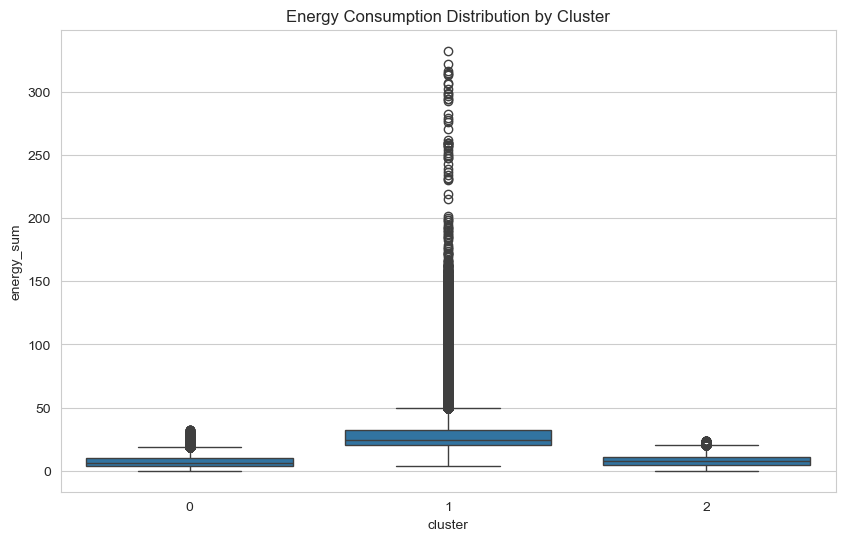

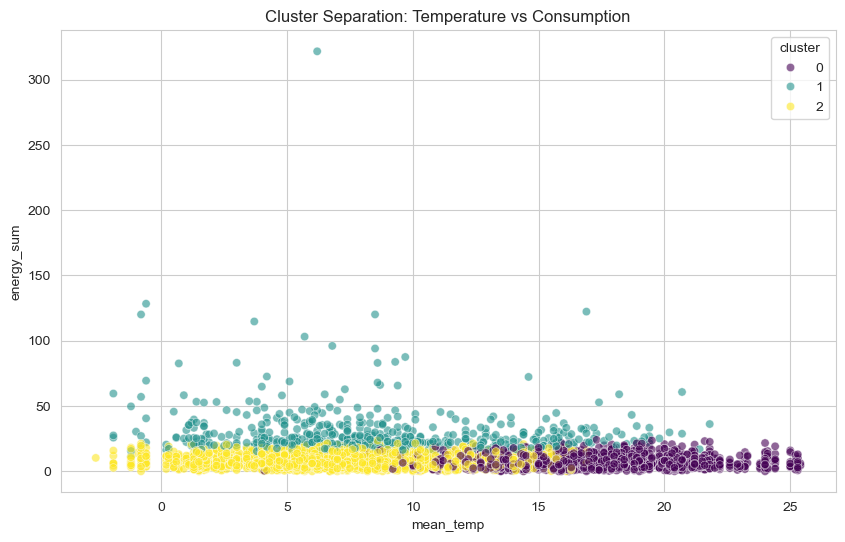

In [11]:
clusterer = EnergyClusterer(n_clusters=3)
df_scaled['cluster'] = clusterer.fit_predict(df_scaled, scaled_feature_names)

# Evaluate
metrics = clusterer.evaluate(df_scaled, scaled_feature_names, df_scaled['cluster'])
print(f"Global Clustering Metrics: {metrics}")

# Visualize Clusters (Boxplot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='energy_sum', data=df_scaled)
plt.title("Energy Consumption Distribution by Cluster")
plt.show()

# Visualize Clusters vs Temperature
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_temp', y='energy_sum', hue='cluster', data=df_scaled.sample(5000), palette='viridis', alpha=0.6)
plt.title("Cluster Separation: Temperature vs Consumption")
plt.show()

#### 3. Time-Based Clustering (Winter Only)
##### *Analyzing behaviors specifically during high-demand winter months.*

In [12]:
winter_cluster_labels = clusterer.fit_time_based(df_scaled, scaled_feature_names, season='Winter')
df_scaled['winter_cluster'] = winter_cluster_labels

# Show counts for Winter clusters
print("Winter Cluster Counts:")
print(df_scaled['winter_cluster'].value_counts())

Winter Cluster Counts:
winter_cluster
0.0    642948
2.0    290131
1.0     47359
Name: count, dtype: int64


#### 4. Forecasting Tasks

Training Consumption Forecaster on 975008 rows...
Short-term Forecast MAE: 2.3403 kWh


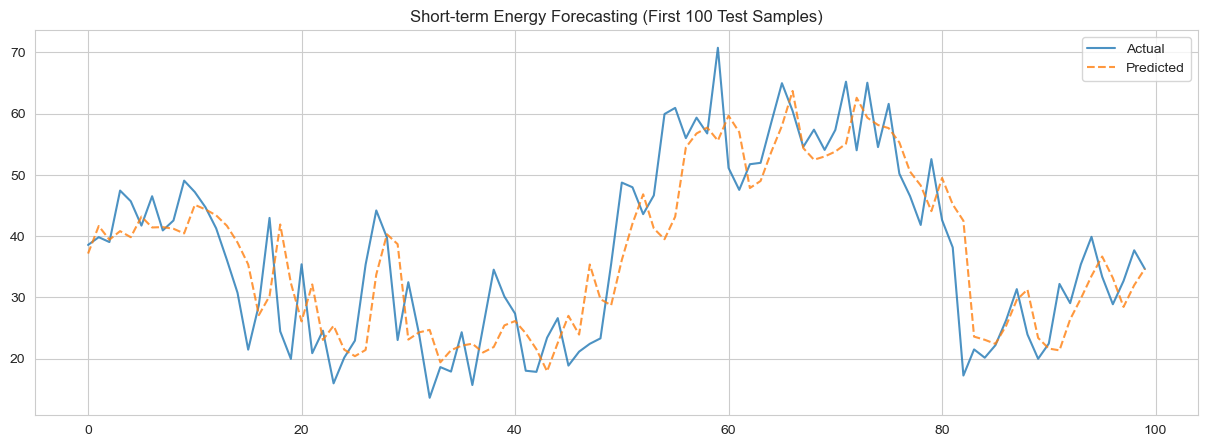

In [13]:
forecaster = Forecaster()

# --- TASK A: Short-term Consumption Forecasting (Regression) ---
# We want to predict 'energy_sum' based on weather + history + holidays
forecast_df = forecaster.prepare_lag_features(df_scaled, target='energy_sum', lags=[1, 2, 7])

# Features for prediction
reg_features = [
    'lag_1', 'lag_2', 'lag_7', 
    'mean_temp', 'is_holiday', 'is_weekend', 'global_radiation'
]

preds, y_test, mae = forecaster.forecast_consumption(forecast_df, reg_features)
print(f"Short-term Forecast MAE: {mae:.4f} kWh")

# Plot Forecast
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual', alpha=0.8)
plt.plot(preds[:100], label='Predicted', alpha=0.8, linestyle='--')
plt.title("Short-term Energy Forecasting (First 100 Test Samples)")
plt.legend()
plt.show()

### Cluster Prediction (Classification)

Can we predict which cluster a day belongs to based solely on weather and date info?
This helps in grid planning.

Training Cluster Classifier...

Cluster Prediction Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    255728
           1       0.20      0.21      0.20     79974
           2       0.85      0.80      0.82    358169

    accuracy                           0.80    693871
   macro avg       0.66      0.67      0.66    693871
weighted avg       0.81      0.80      0.80    693871



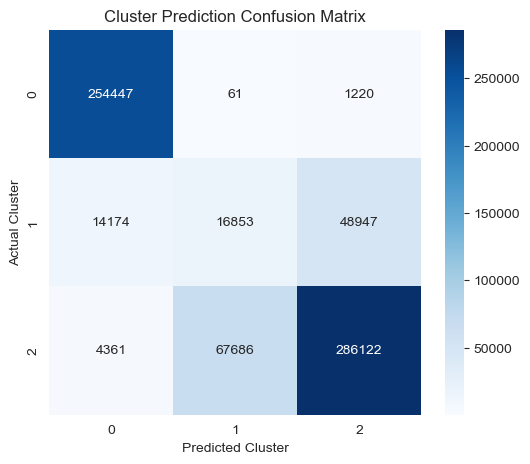

In [14]:
clf_features = ['mean_temp', 'min_temp', 'max_temp', 'global_radiation', 'is_holiday', 'month', 'is_weekend']
clf_preds, clf_y_test, report = forecaster.predict_cluster(df_scaled, clf_features, target_col='cluster')

print("\nCluster Prediction Report:")
print(report)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(clf_y_test, clf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Cluster Prediction Confusion Matrix")
plt.ylabel('Actual Cluster')
plt.xlabel('Predicted Cluster')
plt.show()